<a href="https://colab.research.google.com/github/harvard-visionlab/sroh/blob/main/2024/neuroai_imagenette.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with Imagenette Dataset

Imagenette is a subset of images from 10 Imagenet categories, and can be useful for testing ideas using reasonable resolution images (224x224), but with a much more management dataset (thousands instead of millions of images).

In [ ]:
from torchvision.datasets import ImageFolder, ImageNet
from torchvision.datasets.folder import default_loader

class ImageFolderIndex(ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target, index

class ImageNetIndex(ImageNet):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target, index

class ImagenetteRemappedLabels(ImageFolderIndex):
    labelmap = {0: 0, 1: 217, 2: 482, 3: 491, 4: 497, 5: 566, 6: 569, 7: 571, 8: 574, 9: 701}

    def __init__(self, root, transform=None, target_transform=None, loader=default_loader, is_valid_file=None):
        super(ImagenetteRemappedLabels, self).__init__(root, transform=transform, target_transform=target_transform, loader=loader, is_valid_file=is_valid_file)

        # update labels to use new labels
        self.imgs = [(fname,self.labelmap[label]) for fname,label in self.imgs]
        self.samples = self.imgs


In [ ]:
import os
import sys
import re
import errno
import threading
import hashlib
import warnings
import tarfile
import zipfile
from urllib.parse import urlparse
from urllib.request import urlopen, Request
from pathlib import Path
from tqdm import tqdm

import torch
from typing import Any, Callable, Dict, List, Mapping, Optional, Type, TypeVar, Union
from torch.hub import download_url_to_file

default_cache_dir = os.path.join("./data")

def download_if_needed(url, cache_dir=default_cache_dir, progress=True, check_hash=False,
                       delete_archive=True):
    # Parse the URL to extract the filename
    parsed_url = urlparse(url)
    filename = os.path.basename(parsed_url.path)

    # Extract basename excluding file extensions
    extensions = "".join(Path(filename).suffixes)
    basename = Path(filename).name.replace(extensions, "")

    # Determine the directory where the extracted contents will be stored
    extract_dir = os.path.join(cache_dir, basename)

    # Check if the directory already exists
    if os.path.exists(extract_dir):
        # The directory exists, no need to download and extract
        return extract_dir

    # Download the file as the directory does not exist
    downloaded_file = download_file(url, cache_dir, progress, check_hash)

    # extract archive
    print(f"Extracting file {downloaded_file} to folder {extract_dir}")
    extract_archive(downloaded_file, extract_dir, delete_archive=delete_archive, show_progress=progress)

    return extract_dir

def download_file(url, cache_dir=default_cache_dir, progress=True, check_hash=True):

    if url.startswith("http://") or url.startswith("https://"):
        cached_filename = download_from_url(url, data_dir=cache_dir, progress=progress, check_hash=check_hash)
    else:
        raise ValueError(f"URL should be a valid web url http/https://example.com/<filename>: {url}")

    return cached_filename

def download_from_url(url: str, data_dir: Optional[str] = None, progress: bool = True, check_hash: bool = False,
                      file_name: Optional[str] = None) -> Dict[str, Any]:
    r"""Downloads the object at the given URL.

    If downloaded file is a .tar file or .tar.gz file, it will be automatically
    decompressed.

    If the object is already present in `data_dir`, it's deserialized and
    returned.

    The default value of ``data_dir`` is ``<hub_dir>/../data`` where
    ``hub_dir`` is the directory returned by :func:`~torch.hub.get_dir`.

    Args:
        url (str): URL of the object to download
        data_dir (str, optional): directory in which to save the object
        progress (bool, optional): whether or not to display a progress bar to stderr.
            Default: True
        check_hash(bool, optional): If True, the filename part of the URL should follow the naming convention
            ``filename-<sha256>.ext`` where ``<sha256>`` is the first eight or more
            digits of the SHA256 hash of the contents of the file. The hash is used to
            ensure unique names and to verify the contents of the file.
            Default: False
        file_name (str, optional): name for the downloaded file. Filename from ``url`` will be used if not set.

    Example:
        >>> state_dict = torch.hub.load_state_dict_from_url('https://s3.amazonaws.com/pytorch/models/resnet18-5c106cde.pth')

    """
    # Issue warning to move data if old env is set
    if os.getenv('TORCH_MODEL_ZOO'):
        warnings.warn('TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead')

    if data_dir is None:
        hub_dir = torch.hub.get_dir()
        data_dir = default_cache_dir

    HASH_REGEX = re.compile(r'-([a-f0-9]{4,64})\.')

    try:
        os.makedirs(data_dir)
    except OSError as e:
        if e.errno == errno.EEXIST:
            # Directory already exists, ignore.
            pass
        else:
            # Unexpected OSError, re-raise.
            raise

    parts = urlparse(url)
    filename = os.path.basename(parts.path)
    if file_name is not None:
        filename = file_name
    cached_file = os.path.join(data_dir, filename)
    if not os.path.exists(cached_file):
        sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
        hash_prefix = None
        if check_hash:
            #r = HASH_REGEX.search(filename)  # r is Optional[Match[str]]
            #hash_prefix = r.group(1) if r else None
            matches = HASH_REGEX.findall(filename) # matches is Optional[Match[str]]
            hash_prefix = matches[-1] if matches else None

        download_url_to_file(url, cached_file, hash_prefix, progress=progress)

    return cached_file

def extract_archive(archive_path, extract_to, delete_archive=True, show_progress=True, progress_interval=0.005):
    if not os.path.exists(archive_path):
        raise FileNotFoundError(f"No archive file found at {archive_path}")

    def _report_progress(members, total):
        last_reported = 0
        interval_count = max(1, int(total * progress_interval))  # Calculate the interval count
        for i, member in enumerate(members):
            if show_progress and (i - last_reported >= interval_count or i == total - 1):
                print(f"Extracting file {i+1}/{total} ({(i+1)/total*100:.1f}%)", end='\r')
                last_reported = i
            yield member

    # Determine the archive type and extract
    if archive_path.endswith(('.tar', '.tar.gz', '.tgz', '.gz')):
        with tarfile.open(archive_path, 'r:*') as archive:
            members = archive.getmembers()
            archive.extractall(path=extract_to, members=_report_progress(members, len(members)))
    elif archive_path.endswith('.zip'):
        with zipfile.ZipFile(archive_path, 'r') as archive:
            members = archive.infolist()
            for i, member in enumerate(_report_progress(members, len(members))):
                archive.extract(member, path=extract_to)
    else:
        raise ValueError(f"Unsupported archive type for file {archive_path}")

    print()  # Print newline at end
    # Optionally delete the archive after extraction
    if delete_archive:
        os.remove(archive_path)

In [ ]:
import os

def find_folder(data_dir, split):
    for root, dirs, files in os.walk(data_dir):
        if split in dirs:
            return os.path.join(root, split)
    return None  # Return None if not found

def imagenette2_s320_remap1k(split, cache_dir='./data', transform=None, **kwargs):
    url = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz'
    data_dir = download_if_needed(url, cache_dir=cache_dir)
    root_dir = find_folder(data_dir, split)
    dataset = ImagenetteRemappedLabels(root_dir, transform=transform, **kwargs)

    if split=="val":
        assert len(dataset)==3925, f"Oops, expected 3925 images, got {len(dataset)}"
    elif split=="train":
        assert len(dataset)==9469, f"Oops, expected 9469 images, got {len(dataset)}"

    return dataset

In [ ]:
dataset = imagenette2_s320_remap1k('val')
dataset

Dataset ImagenetteRemappedLabels
    Number of datapoints: 3925
    Root location: ./data/imagenette2-320/imagenette2-320/val

482 1000


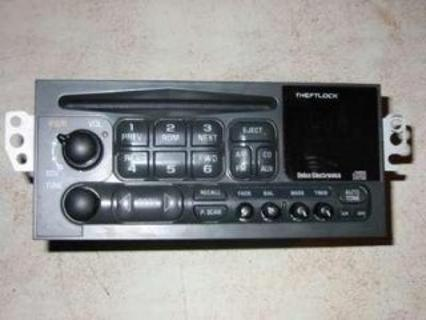

In [ ]:
img,label,index = dataset[1000]
print(label, index)
img

In [ ]:
from torchvision import models

# model = models.resnet18(weights='IMAGENET1K_V1')
# model = models.resnet18(weights='IMAGENET1K_V2') # DEFAULT
model = models.alexnet(weights='DEFAULT') # pretrained=True
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

scramble_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # add your stramble transform
    # Scramble(block_size=(2,2))
    transforms.ToTensor(),
    normalize
])

transform

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [ ]:
dataset = imagenette2_s320_remap1k('val', transform=transform)
dataset

Dataset ImagenetteRemappedLabels
    Number of datapoints: 3925
    Root location: ./data/imagenette2-320/imagenette2-320/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
dataloader = DataLoader(dataset, batch_size=100, num_workers=2, shuffle=False, pin_memory=True)
dataloader

In [ ]:
batch = next(iter(dataloader))

In [ ]:
imgs = batch[0]
labels = batch[1]
indexes = batch[2]

In [ ]:
imgs.shape, labels.shape, indexes.shape

(torch.Size([100, 3, 224, 224]), torch.Size([100]), torch.Size([100]))

In [ ]:
indexes

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
        90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

In [ ]:
model.eval()
with torch.no_grad():
  output = model(imgs)
output.shape

torch.Size([100, 1000])

In [ ]:
output.argmax(dim=1)

tensor([238, 335, 335, 260, 899, 335, 335, 335, 335, 335, 899, 335, 899, 335,
        899, 899, 335, 335, 260, 705, 260, 335, 899, 335, 335, 335, 899, 335,
        335, 335, 335, 335, 335, 335, 335, 335, 335, 899, 335, 335, 335, 899,
        260, 899, 335, 335, 335, 335, 335, 335, 335, 335, 440, 899, 335, 899,
        335, 335, 335, 335, 335, 238, 335, 899, 899, 899, 335, 335, 335, 335,
        899, 335, 335, 899, 899, 335, 335, 335, 335, 899, 335, 335, 335, 899,
        899, 335, 335, 899, 335, 335, 335, 335, 335, 260, 335, 335, 335, 335,
        899, 899])

In [ ]:
accuracy = (output.argmax(dim=1) == labels).numpy().astype(float)
accuracy

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
accuracy.mean()

0.0